In [5]:
# Start with loading all necessary libraries
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGwebapptest;'
                            'DATABASE=BedView;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select cn.Diagnosis,ps.SpecialtyDesc,pn.AmuTriage from tblClinicalNote cn inner join tblPatientSpell ps on ps.pkPatientSpellID=cn.fkPatientSpellID inner join tblPatientNote pn on pn.fkPatientSpellID=ps.pkPatientSpellID"
df = pd.read_sql(query, sql_conn)
df = df.dropna()
df

,Diagnosis,SpecialtyDesc,AmuTriage
0,Moderate-Severe Dementia\nDelayed discharge fr...,Geriatric Medicine,MOPRS
1,Prolonged medical admission\nCOPD\nCAP\nOld ri...,Respiratory & Thoracic Med,-1
2,1. Lewy body dementia,Respiratory & Thoracic Med,GIM
3,For Fast track\nRecurrent pneumonias\nHOOF sen...,Geriatric Medicine,MOPRS
4,Blocked NG - taken out\nDelirious\nHigh re-fee...,Geriatric Medicine,CARDIO
5,1) Korsakoff's\n,Respiratory & Thoracic Med,GIM
6,"Ad/m 6/10, PORTS,\nKW = Sadie\n1. PEA arrest 2...",Specialist Rehabilitation,GASTRO
7,Medically stable for DC\nHAP: on doxy\nBG: syn...,Geriatric Medicine,MOPRS
8,Falls\nDementia\nPost Delirium\nNew R # NOF - ...,Geriatric Medicine,MOPRS
9,MFFD,Geriatric Medicine,MOPRS


In [48]:
#df = df[df.index < 10000]
df_19 = df[df['Diagnosis'].str.lower().str.contains(" over-dose ",regex=False)]
print(df_19['Diagnosis'].values)

[]


In [20]:
snomedct = pd.read_csv('sct2_Description_Snapshot-en_INT_20190731.txt',sep="\t",usecols=['term'])
consecutive_caps_after = snomedct['term'].str.findall(r"((?:\b[A-Za-z]+\b\s)+\([A-Z][A-Z]+\))")
consecutive_caps_after = consecutive_caps_after[consecutive_caps_after.astype(str)!='[]']
consecutive_caps_after = consecutive_caps_after.dropna()
slist = []
for x in consecutive_caps_after:
    slist.extend(x)

term_to_abbreviation_dict = {}
for l in slist:
    inside_brackets = re.findall(r"\(([A-Za-z]+)\)", l)[0]
    len_inside_brackets = len(inside_brackets)
    num_words = len(l.split()) - 1
    if len_inside_brackets == num_words:
        words_before_brackets = []
        for i in range(len_inside_brackets):
            if i<num_words: words_before_brackets.insert(0,l.split(" ")[-i-2])
        string_before_brackets = " ".join(words_before_brackets)
        if all(words_before_brackets[i].lower()[0]==inside_brackets[i].lower() for i in range(len_inside_brackets)):
            if inside_brackets not in term_to_abbreviation_dict.values():
                term_to_abbreviation_dict[string_before_brackets] = inside_brackets
for key,val in dict(term_to_abbreviation_dict).items():
    if val=='OD': del term_to_abbreviation_dict[key]
    elif val=='PIVOTAL': del term_to_abbreviation_dict[key]
        

consecutive_caps_before = snomedct['term'].str.findall(r"[A-Za-z][A-Za-z]+\s\((?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+\)")
consecutive_caps_before = consecutive_caps_before[consecutive_caps_before.astype(str)!='[]']
consecutive_caps_before = consecutive_caps_before.dropna()
slist = []
for x in consecutive_caps_before:
    slist.extend(x)
for l in slist:
    inside_brackets = re.findall(r"\((?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+\)", l)[0]
    inside_brackets = inside_brackets.strip('()')
    words_inside_brackets = inside_brackets.split()
    num_words_inside_brackets = len(words_inside_brackets)
    word_before_brackets = l.split()[0]
    if num_words_inside_brackets==len(word_before_brackets) and all(words_inside_brackets[i].lower()[0]==word_before_brackets[i].lower() for i in range(num_words_inside_brackets)):
        if word_before_brackets not in term_to_abbreviation_dict.values():
            term_to_abbreviation_dict[inside_brackets] = word_before_brackets
            

consecutive_caps_dash = snomedct['term'].str.findall(r"[A-Za-z][A-Za-z]+\s\-\s(?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+")
consecutive_caps_dash = consecutive_caps_dash[consecutive_caps_dash.astype(str)!='[]']
consecutive_caps_dash = consecutive_caps_dash.dropna()
slist = []
for x in consecutive_caps_dash:
    slist.extend(x)
for l in slist:
    after_dash = l.split(' - ')[1]
    words_after_dash = after_dash.split()
    num_words_after_dash = len(words_after_dash)
    word_before_dash = l.split(' - ')[0]
    if num_words_after_dash==len(word_before_dash) and all(words_after_dash[i].lower()[0]==word_before_dash[i].lower() for i in range(num_words_after_dash)):
        if word_before_dash not in term_to_abbreviation_dict.values():
            term_to_abbreviation_dict[after_dash] = word_before_dash



consecutive_caps_after = df['Diagnosis'].str.findall(r"((?:\b[A-Za-z]+\b\s)+\([A-Z][A-Z]+\))")
consecutive_caps_after = consecutive_caps_after[consecutive_caps_after.astype(str)!='[]']
consecutive_caps_after = consecutive_caps_after.dropna()
slist = []
for x in consecutive_caps_after:
    slist.extend(x)

for l in slist:
    inside_brackets = re.findall(r"\(([A-Za-z]+)\)", l)[0]
    len_inside_brackets = len(inside_brackets)
    num_words = len(l.split()) - 1
    if len_inside_brackets == num_words:
        words_before_brackets = []
        for i in range(len_inside_brackets):
            if i<num_words: words_before_brackets.insert(0,l.split()[-i-2])
        string_before_brackets = " ".join(words_before_brackets)
        if all(words_before_brackets[i].lower()[0]==inside_brackets[i].lower() for i in range(len_inside_brackets)):
            if inside_brackets not in term_to_abbreviation_dict.values():
                term_to_abbreviation_dict[string_before_brackets] = inside_brackets
for key,val in dict(term_to_abbreviation_dict).items():
    if val=='OD': del term_to_abbreviation_dict[key]
    elif val=='PIVOTAL': del term_to_abbreviation_dict[key]
        

consecutive_caps_before = df['Diagnosis'].str.findall(r"[A-Za-z][A-Za-z]+\s\((?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+\)")
consecutive_caps_before = consecutive_caps_before[consecutive_caps_before.astype(str)!='[]']
consecutive_caps_before = consecutive_caps_before.dropna()
slist = []
for x in consecutive_caps_before:
    slist.extend(x)
for l in slist:
    inside_brackets = re.findall(r"\((?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+\)", l)[0]
    inside_brackets = inside_brackets.strip('()')
    words_inside_brackets = inside_brackets.split()
    num_words_inside_brackets = len(words_inside_brackets)
    word_before_brackets = l.split()[0]
    if num_words_inside_brackets==len(word_before_brackets) and all(words_inside_brackets[i].lower()[0]==word_before_brackets[i].lower() for i in range(num_words_inside_brackets)):
        if word_before_brackets not in term_to_abbreviation_dict.values():
            term_to_abbreviation_dict[inside_brackets] = word_before_brackets
            

consecutive_caps_dash = df['Diagnosis'].str.findall(r"[A-Za-z][A-Za-z]+\s\-\s(?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+")
consecutive_caps_dash = consecutive_caps_dash[consecutive_caps_dash.astype(str)!='[]']
consecutive_caps_dash = consecutive_caps_dash.dropna()
slist = []
for x in consecutive_caps_dash:
    slist.extend(x)
for l in slist:
    after_dash = l.split('-')[1]
    words_after_dash = after_dash.split()
    num_words_after_dash = len(words_after_dash)
    word_before_dash = l.split(' - ')[0]
    if num_words_after_dash==len(word_before_dash) and all(words_after_dash[i].lower()[0]==word_before_dash[i].lower() for i in range(num_words_after_dash)):
        if word_before_dash not in term_to_abbreviation_dict.values():
            after_dash = after_dash.strip()
            term_to_abbreviation_dict[after_dash] = word_before_dash
        
term_to_abbreviation_dict['troponin'] = 'trop'
term_to_abbreviation_dict['exac'] = 'exacerbation'
term_to_abbreviation_dict['infective exacerbation'] = 'ie'
term_to_abbreviation_dict['infected exacerbation'] = 'ie'
term_to_abbreviation_dict['ie of copd'] = 'iecopd'
term_to_abbreviation_dict['ie copd'] = 'iecopd'
term_to_abbreviation_dict['ie- copd'] = 'iecopd'
term_to_abbreviation_dict['ie-copd'] = 'iecopd'
term_to_abbreviation_dict['pulmonary embolism'] = 'pe'
term_to_abbreviation_dict['nebuliser'] = 'neb'
term_to_abbreviation_dict['nebulizer'] = 'neb'
term_to_abbreviation_dict['nebulisers'] = 'nebs'
term_to_abbreviation_dict['nebulizers'] = 'nebs'
term_to_abbreviation_dict['influenza'] = 'flu'
term_to_abbreviation_dict['over dose'] = 'overdose'
term_to_abbreviation_dict['od'] = 'overdose'

#term_to_abbreviation_dict = {key.lower():val.lower() for (key,val) in term_to_abbreviation_dict.items()}
for key,val in term_to_abbreviation_dict.items():
    print(key+" & "+val+'\\\\')

dead on arrival & DOA\\
minimum bactericidal concentration & MBC\\
increased anion gap & IAG\\
minimum inhibitory concentration & MIC\\
Atrial natriuretic factor & ANF\\
Anaplastic large cell lymphoma & ALCL\\
Estrogen receptor assay & ERA\\
Thyrotropin releasing hormone & TRH\\
normal anion gap & NAG\\
Prothrombin time & PT\\
Foreign body & FB\\
Peripherally inserted central & PIC\\
Transcutaneous Electrical Nerve Stimulation & TENS\\
Vulval intraepithelial neoplasia & VIN\\
International normalised ratio & INR\\
Forced vital capacity & FVC\\
sexually transmitted disease & STD\\
Direct fluorescent antibody & DFA\\
Recreational vehicle & RV\\
Human immunodeficiency virus & HIV\\
World Health Organization & WHO\\
Ductal carcinoma in situ & DCIS\\
Natural killer & NK\\
High density lipoprotein & HDL\\
Intermediate density lipoprotein & IDL\\
Very low density lipoprotein & VLDL\\
White blood cells & WBC\\
Low density lipoprotein & LDL\\
Human leukocyte antigen & HLA\\
Tumor growth factor 

In [4]:
df_AMU = df[df['AmuTriage']!='-1'].copy()
df_AMU

,Diagnosis,SpecialtyDesc,AmuTriage
0,Moderate-Severe Dementia\nDelayed discharge fr...,Geriatric Medicine,MOPRS
2,1. Lewy body dementia,Respiratory & Thoracic Med,GIM
3,For Fast track\nRecurrent pneumonias\nHOOF sen...,Geriatric Medicine,MOPRS
4,Blocked NG - taken out\nDelirious\nHigh re-fee...,Geriatric Medicine,CARDIO
5,1) Korsakoff's\n,Respiratory & Thoracic Med,GIM
6,"Ad/m 6/10, PORTS,\nKW = Sadie\n1. PEA arrest 2...",Specialist Rehabilitation,GASTRO
7,Medically stable for DC\nHAP: on doxy\nBG: syn...,Geriatric Medicine,MOPRS
8,Falls\nDementia\nPost Delirium\nNew R # NOF - ...,Geriatric Medicine,MOPRS
9,MFFD,Geriatric Medicine,MOPRS
10,To sit out daily.\nTry to progress from hoist....,Geriatric Medicine,MOPRS


In [5]:
df_nonAMU = df[df['AmuTriage']=='-1'].copy()
df_nonAMU

,Diagnosis,SpecialtyDesc,AmuTriage
1,Prolonged medical admission\nCOPD\nCAP\nOld ri...,Respiratory & Thoracic Med,-1
22,Delirium - on going despite normalisation of b...,Geriatric Medicine,-1
27,Debridement of Left TKR and re application of...,Orthopaedic - Knee,-1
31,Adm: 15/7\nPC: Headache + confusion\nImp: Resi...,Stroke Medicine,-1
32,AMBER\ncompleted Abx for HAP\nSBO,Geriatric Medicine,-1
44,,Rehabilitation,-1
52,"US - Adm: 27/07\nPC: Found on Floor >24hrs, RS...",Rehabilitation,-1
130,Decomp ETOH Liver Disease\nSBP,General Medicine,-1
164,ICOPD,Respiratory & Thoracic Med,-1
212,1. Chest pain (ACS vs. severe AS)\n2. Metastat...,General Medicine,-1


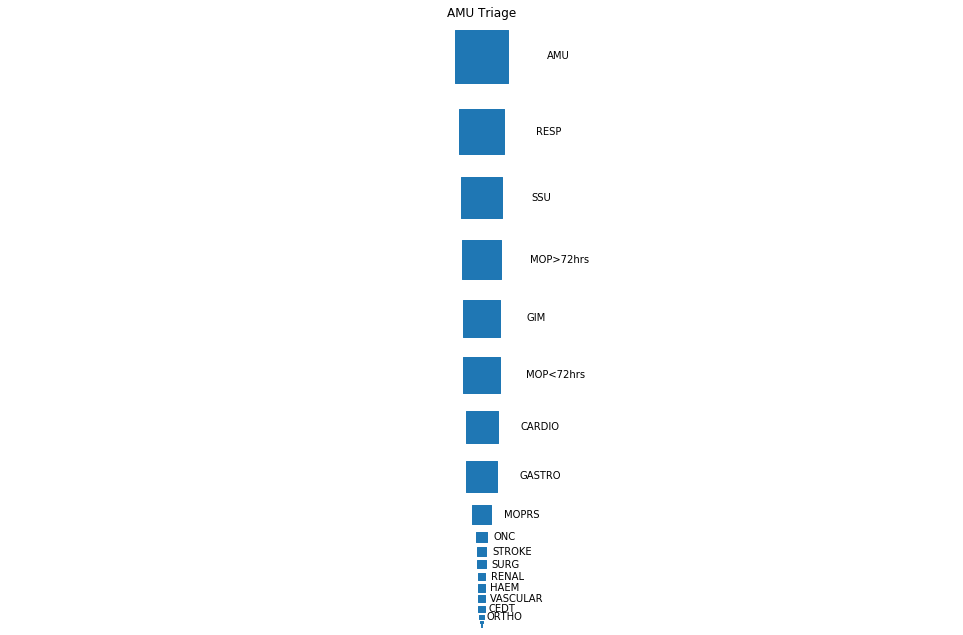

In [6]:
def triage_plot(dataframe):
    triage_counts = dataframe['AmuTriage'].value_counts()
    triage_counts = triage_counts.rename({'-1':'not via AMU'})
    sizes = triage_counts/4
    y = []
    cumulative_y = 0
    for size in sizes:
        cumulative_y+=np.sqrt(size)/2
        y.append(cumulative_y)
        cumulative_y+=np.sqrt(size)/2
    plt.figure(figsize=(17,14*y[-1]/500))
    plt.scatter(x=np.zeros(len(triage_counts)),y=y,s=sizes,marker='s')
    plt.ylim(max(y),np.sqrt(min(y)))
    for i,triage in enumerate(triage_counts.index):
        if i==0 or y[i]-y[i-1]>4: plt.text((y[-1]/500)*np.sqrt(sizes)[i]/10000,y[i],triage,va='center')
    plt.gca().axis('off');
    plt.title('AMU Triage')
    plt.show()
triage_plot(df_AMU)

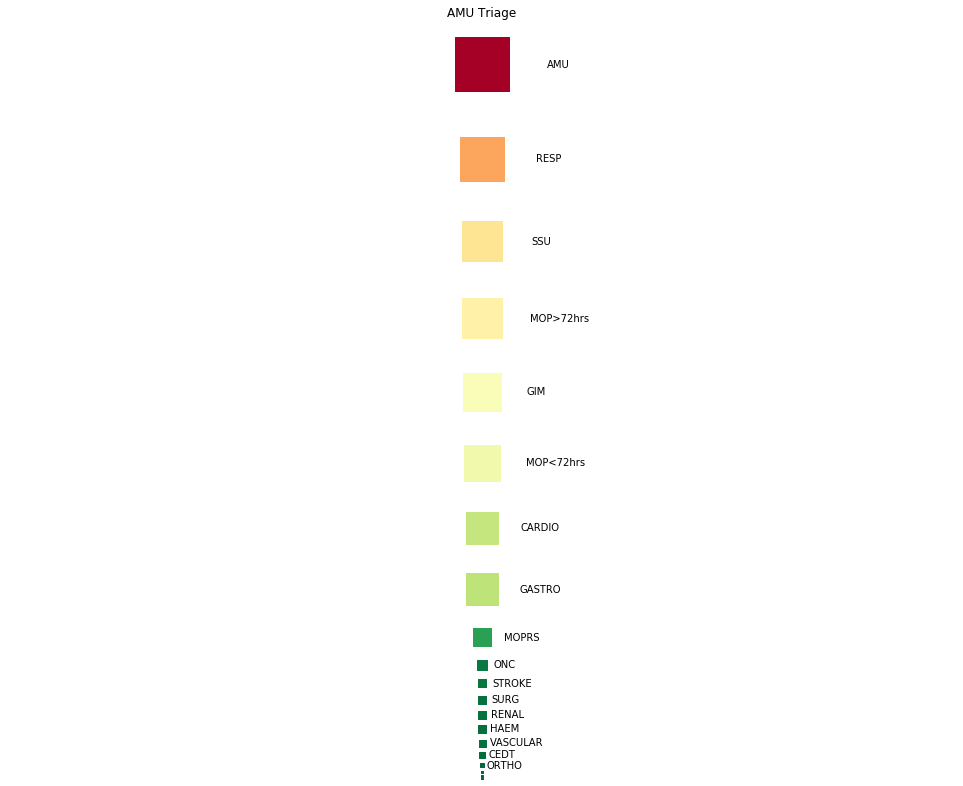

In [122]:
def triage_plot(dataframe):
    triage_counts = dataframe['AmuTriage'].value_counts()
    triage_counts = triage_counts.rename({'-1':'not via AMU'})
    
    sizes = triage_counts/4
    y = []
    cumulative_y = 0
    for size in sizes:
        cumulative_y+=np.sqrt(size)/2
        y.append(cumulative_y)
        cumulative_y+=np.sqrt(size)/2
        
    cm = plt.get_cmap('RdYlGn_r')
    colors = cm(sizes/max(sizes))
    color_dict = {}
    
    plt.figure(figsize=(17,14*y[-1]/400))
    plt.ylim(max(y),np.sqrt(min(y)))
    for i,triage in enumerate(triage_counts.index):
        color_dict[triage] = colors[i]
        plt.scatter(x=0,y=y[i],s=sizes[i],marker='s',color=color_dict[triage])
        if i==0 or y[i]-y[i-1]>4: plt.text((y[-1]/500)*np.sqrt(sizes)[i]/10000,y[i],triage,va='center')
    plt.gca().axis('off');
    plt.title('AMU Triage')
    plt.show()
triage_plot(df_AMU)

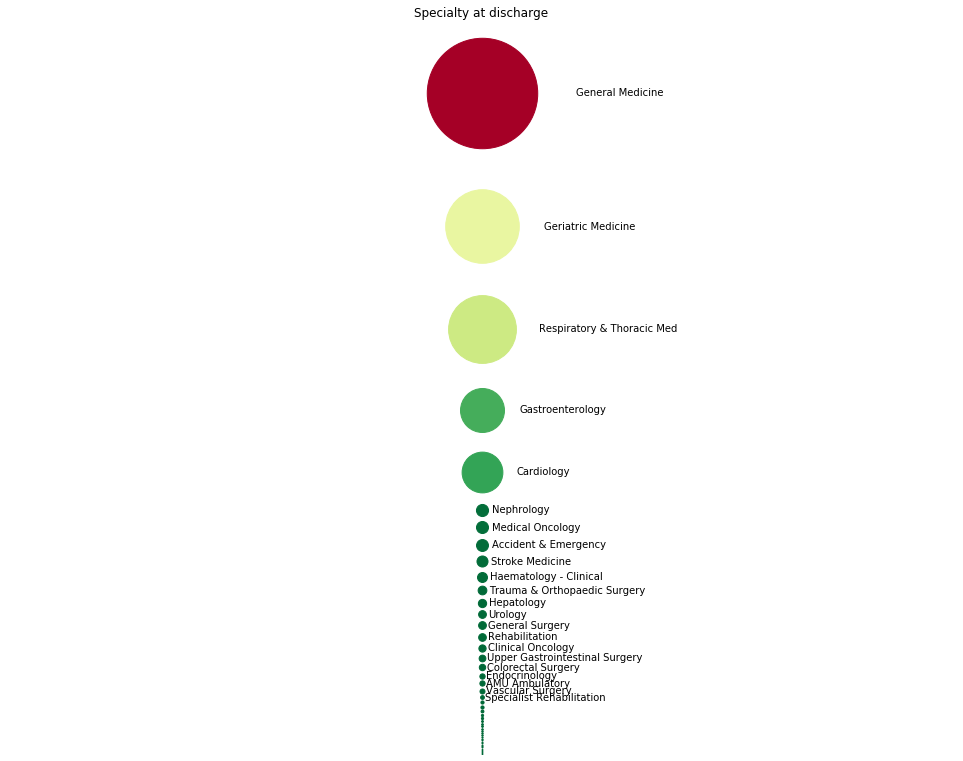

In [120]:
def specialty_plot(dataframe):
    specialty_counts = dataframe['SpecialtyDesc'].value_counts()
    
    sizes = specialty_counts/2
    y = []
    cumulative_y = 0
    for size in sizes:
        cumulative_y+=np.sqrt(size/np.pi)
        y.append(cumulative_y)
        cumulative_y+=np.sqrt(size/np.pi)
        
    cm = plt.get_cmap('RdYlGn_r')
    colors = cm(sizes/max(sizes))
    specialty_color_dict = {}
    
    plt.figure(figsize=(17,14*y[-1]/600))
    plt.ylim(max(y),np.sqrt(min(y)))
    for i,specialty in enumerate(specialty_counts.index):
        specialty_color_dict[specialty] = colors[i]
        plt.scatter(x=0,y=y[i],s=sizes[i],marker='o',color=colors[i])
        if i==0 or y[i]-y[i-1]>4: plt.text((y[-1]/500)*np.sqrt(sizes)[i]/10000,y[i],specialty,va='center')
    plt.gca().axis('off');
    plt.title('Specialty at discharge')
    plt.show()
specialty_plot(df_AMU)

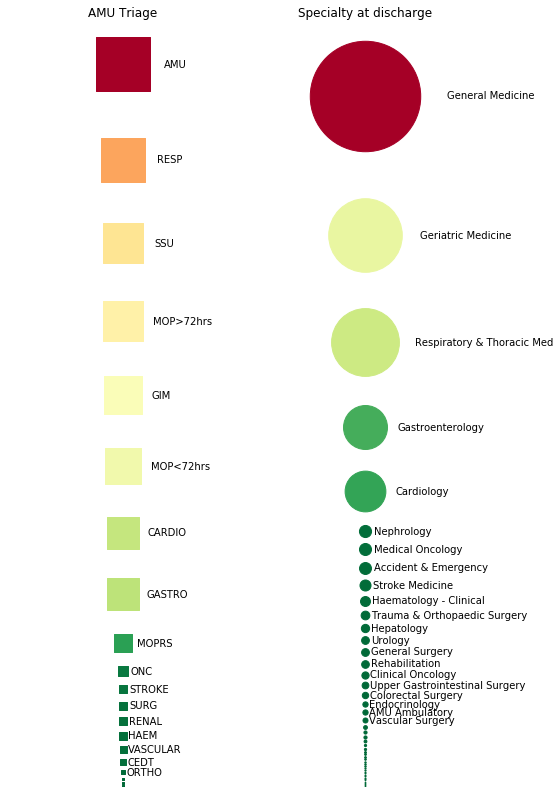

In [125]:
triage_counts = df_AMU['AmuTriage'].value_counts()

triage_sizes = triage_counts/4
triage_y = []
cumulative_triage_y = 0
for size in triage_sizes:
    cumulative_triage_y+=np.sqrt(size)/2
    triage_y.append(cumulative_triage_y)
    cumulative_triage_y+=np.sqrt(size)/2

cm = plt.get_cmap('RdYlGn_r')
triage_colors = cm(triage_sizes/max(triage_sizes))
triage_color_dict = {}


specialty_counts = df_AMU['SpecialtyDesc'].value_counts()

specialty_sizes = specialty_counts/2
specialty_y = []
cumulative_specialty_y = 0
for size in specialty_sizes:
    cumulative_specialty_y+=np.sqrt(size/np.pi)
    specialty_y.append(cumulative_specialty_y)
    cumulative_specialty_y+=np.sqrt(size/np.pi)

specialty_cm_subsection = np.linspace(0, 1, len(specialty_counts))
specialty_colors = cm(specialty_sizes/max(specialty_sizes))
specialty_color_dict = {}

# Display the generated image:
figure, (triage_fig, specialty_fig) = plt.subplots(nrows=1,ncols=2, figsize=(8,14*triage_y[-1]/500))

triage_fig.set_ylim(max(triage_y),np.sqrt(min(triage_y)))
for i,triage in enumerate(triage_counts.index):
    triage_color_dict[triage] = triage_colors[i]
    triage_fig.scatter(x=0,y=triage_y[i],s=triage_sizes[i],marker='s',color=triage_color_dict[triage])
    if i==0 or triage_y[i]-triage_y[i-1]>4: triage_fig.text((specialty_y[-1]/600)*np.sqrt(triage_sizes)[i]/1000,triage_y[i],triage,va='center')
triage_fig.axis('off');
triage_fig.set_title('AMU Triage')

specialty_fig.set_ylim(max(specialty_y),np.sqrt(min(specialty_y)))
for i,specialty in enumerate(specialty_counts.index):
    specialty_color_dict[specialty] = specialty_colors[i]
    specialty_fig.scatter(x=0,y=specialty_y[i],s=specialty_sizes[i],marker='o',color=specialty_color_dict[specialty])
    if i==0 or specialty_y[i]-specialty_y[i-1]>5: specialty_fig.text((specialty_y[-1]/600)*np.sqrt(specialty_sizes)[i]/500,specialty_y[i],specialty,va='center')
specialty_fig.axis('off');
specialty_fig.set_title('Specialty at discharge')
    
plt.tight_layout()
plt.show()